# Ben's Image Repository Client

This client application demonstrates the capabilities of the image repository API.
Though this is a python3 notebook, the REST api allows for clients in many languages;
there could equivalently be a web interface, command-line tool, or other desktop application.

## Imports

We need `json` and `BytesIO` to encode and decode api call parameters, and `requests` to make the calls to the API.

We also use `torch` and `torchvision` to get state-of-the-art imagenet encoding used for reverse image lookup. For more on this, see the main `README.md`.

All other libraries are either auxiliary (`time`) or used for handling images (`pillow`, `matplotlib`, `numpy`)

In [1]:
import time
import json
import torch
import requests
import torchvision
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from torchvision import transforms

## Image display helpers

`imshow` displays a pillow or numpy image. `imshowMany` displays a grid of many images using matplotlib subplots.

In [2]:
%matplotlib inline
def imshow(img):
    plt.imshow(img)
    plt.show()

def imshowMany(imgs, ncols=3):
    nrows = len(imgs) // ncols
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for idx, img in enumerate(imgs):
        if (idx >= nrows * ncols):
            break
        axeslist.ravel()[idx].imshow(img)
        axeslist.ravel()[idx].set_axis_off()
    plt.show()

## Image encoding

This is where the magic happens.
We load the [best pretrained model](https://pytorch.org/docs/stable/torchvision/models.html) `torchvision` gives us,
and use it to encode an image into a 1000-entry vector of probabilities from 0 to 1.

Using this, we can do image-image searching by calculating the Mean-Squared Error (MSE)
between source and destination image pairs, and select the `k` results with the least error.
This allows for efficient queries that do not need to scan the large image files directly.

In [3]:
model = torchvision.models.resnext101_32x8d(pretrained=True)
model.eval()
def encode(img):
    img = img.resize((224, 224))
    img = np.array(img)
    img = np.moveaxis(img, -1, 0)
    img = np.reshape(img, (1, 3, 224, 224))
    img = torch.from_numpy(img)
    img = img.float()
    img /= 255.0
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])(img)
    vals = model(img)
    vals = torch.nn.functional.softmax(vals, dim=1)
    return vals.squeeze().tolist()

def fetchImage(url):
    return Image.open(BytesIO(requests.get(url).content))

## API Capabilities

These functions encapsulate the calls to the REST api, and encapsulate their core behaviours for later examples.
Supported functionality includes:

- Image upload from URL
- Direct image download by ID
- Image deletion by ID
- Search for images that have a given tag
- Search for images that are similar to a given image

In [4]:
API_ROOT = "https://7vwdb59gji.execute-api.us-east-2.amazonaws.com/prod"

def upload(url, tags=[], owner='jupyter-client'):
    params = json.dumps({
        'url': url,
        'tags': tags,
        'owner': owner,
        'encoding': encode(fetchImage(url))
    })
    
    r = requests.post(API_ROOT + "/image", data=params)
    data = r.json()
    return data['id']

def download(id):
    r = requests.get("{}/image/{}".format(API_ROOT, id))
    b = BytesIO(r.content)
    return Image.open(b)

def delete(id):
    return requests.delete("{}/image/{}".format(API_ROOT, id))

def tagSearch(tag, limit=None):
    params = {}
    if (limit is not None):
        params['limit'] = limit
    params = json.dumps(params)
    r = requests.post("{}/image/search/tags/{}".format(API_ROOT, tag), data=params)
    data = r.json()
    return list(map(lambda item: item['id'], data))

def imageSearch(url, limit=None):
    params = {
        'encoding': encode(fetchImage(url))
    }
    if (limit is not None):
        params['limit'] = limit
    params = json.dumps(params)
    r = requests.post(API_ROOT + "/image/search", data=params)
    data = r.json()
    return list(map(lambda item: item['id'], data))

# Usage

With the setup complete, let's put it to use!

## Populate the repository

This function uploads images in bulk to the repository.
These links represent the only images currently available.

Because of the scalability of the AWS backend used, this will continue to work for up to millions of images.
For cost reasons, I have kept this quantity small.

Also, I have added a small sleep of 0.25s in the upload loop so that I can monitor the progress in the AWS console.
Requests calls are synchronous, so this is not required.

In [5]:
def populate():
    images = {
        'https://static.flickr.com/3112/3149370979_a9127af690.jpg': ['table', 'outdoors', 'bench', 'park'],
        'https://static.flickr.com/175/414203423_6be41337f5.jpg': ['winter', 'snow', 'cars'],
        'https://static.flickr.com/3598/3325758177_8e3422cde2.jpg': ['stairs', 'outdoors', 'rain'],
        'https://static.flickr.com/12/18201625_aff60520f4.jpg': ['bridge', 'outdoors'],
        'https://static.flickr.com/2432/3849135352_ae91cc07ed.jpg': ['flower', 'architecture'],
        'https://static.flickr.com/2694/4262569852_557dfed376.jpg': ['tunnel'],
        'https://static.flickr.com/3574/3377257984_f1d9d3873f.jpg': ['port', 'boats', 'rainbow'],
        'https://static.flickr.com/1303/769005800_bcaf9da7d2.jpg': ['beach'],
        'https://static.flickr.com/2461/3615357404_e7098358ec.jpg': ['flower', 'sky', 'cross'],
        'https://static.flickr.com/3248/2979301618_9160a4b31e.jpg': ['beach', 'sky', 'nature'],
        'https://static.flickr.com/3041/2940624379_27c3f7ff62.jpg': ['tree', 'nature', 'sky', 'sunset'],
        'https://static.flickr.com/16/20996853_83a9ce50f1.jpg': ['dog', 'nest'],
        'https://static.flickr.com/117/262787392_704e53b83b.jpg': ['flower', 'nature'],
        'https://static.flickr.com/3231/2673456541_5b9ef64bf1.jpg': ['sky', 'clouds', 'plane'],
        'https://static.flickr.com/3561/3695796161_8769473a66.jpg': ['flower', 'field', 'nature', 'sky', 'tree'],
        'https://static.flickr.com/3023/2997905903_8382feaf5c.jpg': ['tree', 'nature', 'hike'],
        'https://static.flickr.com/2003/1803430577_101ac95b14.jpg': ['house', 'architecture'],
        'https://static.flickr.com/2013/2114297604_4bd4792521.jpg': ['bird', 'winter'],
        'https://static.flickr.com/2684/4443594503_0595362a32.jpg': ['cat', 'cloud'],
        'https://static.flickr.com/110/314692479_beafa6205a.jpg': ['fjord', 'lake', 'nature', 'sky'],
        'https://static.flickr.com/6198/6057096627_ec7c4e5c02.jpg': ['flower', 'drawing', 'art'],
        'https://static.flickr.com/4050/4582266241_c1d323f69d.jpg': ['grass', 'field', 'nature', 'farm'],
        'https://static.flickr.com/2627/3677843120_d01845953d.jpg': ['tree', 'sky', 'dark'],
        'https://static.flickr.com/4124/5183437764_ae8a05141e.jpg': ['livestock', 'sky'],
        'https://static.flickr.com/5242/5213244829_d76c714dc4.jpg': ['nature', 'tree', 'city'],
        'https://static.flickr.com/189/529642642_2f8292898c.jpg': ['building', 'sky', 'architecture'],
        'https://static.flickr.com/1323/854673111_2dfa6e895d.jpg': ['cat'],
        'https://static.flickr.com/28/43878072_9b440a24af.jpg': ['cat', 'kitty', 'colorful'],
        'https://static.flickr.com/5253/5579967450_132869f320_b.jpg': ['cat', 'grass']
    }
    for url, tags in images.items():
        upload(url, tags, 'static.flickr.com')
        time.sleep(0.25)
    print('Done!')

# populate()

## Search for similar images

This demonstrates the capability of the image-based searching.
First displayed is the target image, followed by the top 3 matches.

Note that the images currently in the repository are quite few, so the matches are not as exact as they would be with a larger search space.

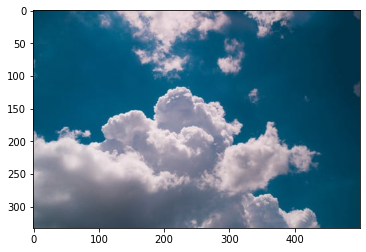

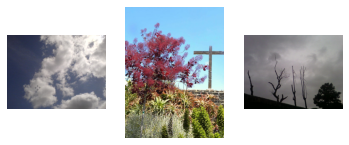

In [6]:
def imageLookup():
    url = "https://images.pexels.com/photos/2093252/pexels-photo-2093252.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500"
    imshow(fetchImage(url))
    matches = imageSearch(url, limit=3)
    imgs = list(map(download, matches))
    imshowMany(imgs)

imageLookup()

## Search for images with a tag

This demonstrates the capability of tag-based searching.
Displayed are the top-3 results for tags `cat`, `nature`, and `tree`, in that order.

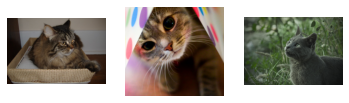

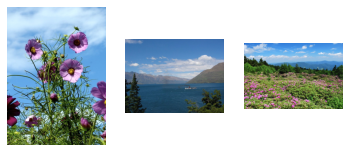

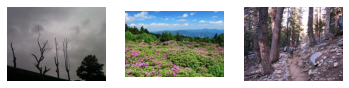

In [7]:
def tagLookup(tag):
    matches = tagSearch(tag, limit=3)
    imgs = list(map(download, matches))[0:3]
    imshowMany(imgs)

tagLookup('cat')
tagLookup('nature')
tagLookup('tree')

## Upload and Delete an image

This demonstrates deletion capability.
We can safely upload and prompty delete an image without permanently polluting the repository.

In [8]:
def uploadAndDelete():
    url = "https://images.pexels.com/photos/2093252/pexels-photo-2093252.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500"
    imgId = upload(url)
    delete(imgId)
    try:
        imshow(download(imgId))
    except:
        print("Image {} deleted successfully".format(imgId))

uploadAndDelete()

Image 294328566221 deleted successfully
